# Dataset Preparation

In [1]:
import tensorflow as tf # type: ignore
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

* loading the IMdB dataset on Tensorflow

In [2]:
# Parameters
vocab_size = 20000  # Number of words to consider as features
max_length = 400    # Maximum length of review (in words)

In [3]:
# Load the IMDB dataset
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

* Preprocess the ImdB Dataset

In [4]:
import numpy as np

# # Check the length of all sequences in the training and testing datasets
train_lengths = [len(sample) for sample in train_data]
test_lengths = [len(sample) for sample in test_data]

# Print statistics about the sequence lengths
print(f"Training sample - Max length: {np.max(train_lengths)}, Min length: {np.min(train_lengths)}, Average length: {np.mean(train_lengths)}")
print(f"Testing sample - Max length: {np.max(test_lengths)}, Min length: {np.min(test_lengths)}, Average length: {np.mean(test_lengths)}")


Training sample - Max length: 2494, Min length: 11, Average length: 238.71364
Testing sample - Max length: 2315, Min length: 7, Average length: 230.8042


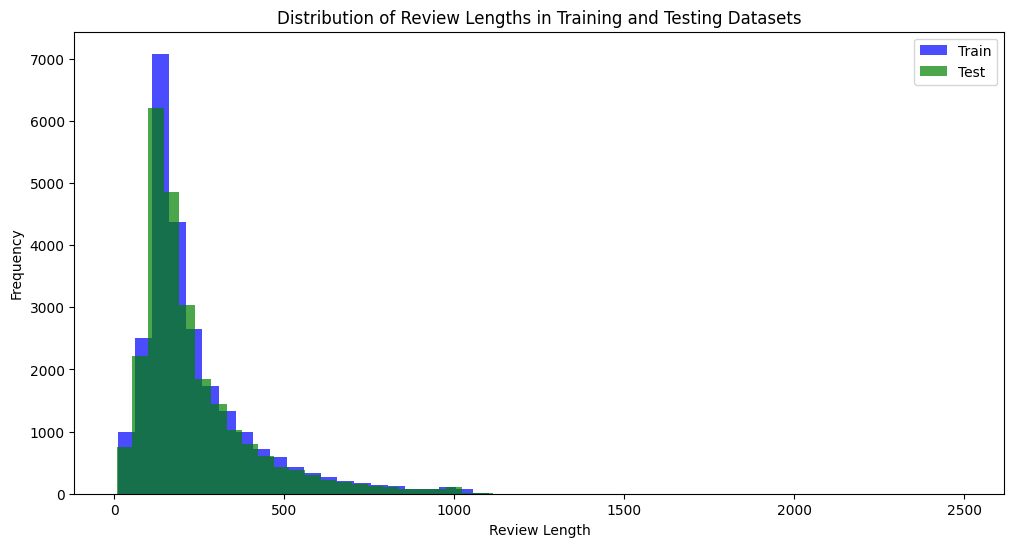

In [5]:
import matplotlib.pyplot as plt # type: ignore

train_lengths = [len(seq) for seq in train_data]
test_lengths = [len(seq) for seq in test_data]

# Plot the distribution of review lengths in both datasets
plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=50, color='blue', alpha=0.7, label='Train')

# Plot testing data
plt.hist(test_lengths, bins=50, color='green', alpha=0.7, label='Test')

# Labeling the plot
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths in Training and Testing Datasets')
plt.legend()
plt.show()

The histogram illustrates the distribution of review lengths in both the training and testing datasets. The x-axis represents review lengths, while the y-axis shows their frequency. The plot reveals that most reviews are short, with a higher frequency at lower lengths and a right-skewed distribution. The training dataset is represented in blue, and the testing dataset in green, showing similar distribution patterns for both datasets.

* Pad the sequences to ensure uniform input length

In [7]:
train_data = pad_sequences(train_data, maxlen=max_length, padding='post', truncating='post')
test_data = pad_sequences(test_data, maxlen=max_length, padding='post', truncating='post')

In [8]:
# Show the tokenized and padded data
print(f'Example padded review: {train_data[0]}')
print(f'Example label: {train_labels[0]}')

Example padded review: [    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670     2     9    35   480   284     5   150     4   172   112
   167     2   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4     2     7  3766
     5   723    36    71    43   530   476    26   400   317    46     7
     4 12118  1029    13   1

In [9]:
# Check the shapes of the preprocessed data
print(f'Training data shape: {train_data.shape}')
print(f'Testing data shape: {test_data.shape}')

Training data shape: (25000, 400)
Testing data shape: (25000, 400)


# Building the RNN Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Flatten, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

In [11]:
# Parameters
embedding_dim = 128
rnn_units = 64
learning_rate = 0.001

In [12]:
# Building the RNN Model with GRU
def build_rnn_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Bidirectional(GRU(units=rnn_units, return_sequences=False)),
        Dropout(rate=0.5),
        Dense(units=32, activation='relu'),
        Dropout(rate=0.5),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

rnn_model = build_rnn_model()
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 128)          2560000   
                                                                 
 bidirectional (Bidirection  (None, 128)               74496     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                        

# Training the Model

In [13]:
# Split the dataset into training and validation sets.  20% of the training data is used for validation.
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [15]:
# Train the model
rnn_history = rnn_model.fit(X_train, 
                            y_train, 
                            epochs=10, 
                            batch_size=64, 
                            validation_data=(X_val, y_val), 
                            callbacks=[early_stopping])

Epoch 1/10
313/313 [==============================] - 228s 714ms/step - loss: 0.6058 - accuracy: 0.6465 - val_loss: 0.4252 - val_accuracy: 0.8148
Epoch 2/10
313/313 [==============================] - 120s 383ms/step - loss: 0.3266 - accuracy: 0.8802 - val_loss: 0.3672 - val_accuracy: 0.8454
Epoch 3/10
313/313 [==============================] - 114s 364ms/step - loss: 0.1977 - accuracy: 0.9362 - val_loss: 0.3729 - val_accuracy: 0.8494
Epoch 4/10
313/313 [==============================] - 119s 380ms/step - loss: 0.1251 - accuracy: 0.9610 - val_loss: 0.3965 - val_accuracy: 0.8682
Epoch 5/10
313/313 [==============================] - 141s 452ms/step - loss: 0.0799 - accuracy: 0.9783 - val_loss: 0.4792 - val_accuracy: 0.8606


The model was trained over 10 epochs. Initially, the model started with a loss of 0.6058 and an accuracy of 64.65% on the training set. As the training progressed, both the training and validation accuracy improved significantly, reaching 97.83% training accuracy by the 5th epoch. However, the validation accuracy showed some fluctuation, peaking at 86.82% in the 4th epoch and slightly decreasing afterward. The validation loss increased over time, indicating potential overfitting, with the model performing better on the training data than on the validation data.

In [16]:
# Evaluate the RNN model on the test set
rnn_val_loss, rnn_val_accuracy = rnn_model.evaluate(X_val, y_val)
print(f'Validation Loss: {rnn_val_loss}')
print(f'Validation Accuracy: {rnn_val_accuracy}')

157/157 [==============================] - 6s 37ms/step - loss: 0.3672 - accuracy: 0.8454
Validation Loss: 0.36724236607551575
Validation Accuracy: 0.8453999757766724


The final evaluation of the model on the validation set resulted in a loss of 0.3672 and an accuracy of 84.54%. This indicates that the model performs reasonably well, with a good balance between precision and generalization, though there may be room for further improvement to increase its accuracy on the validation data.

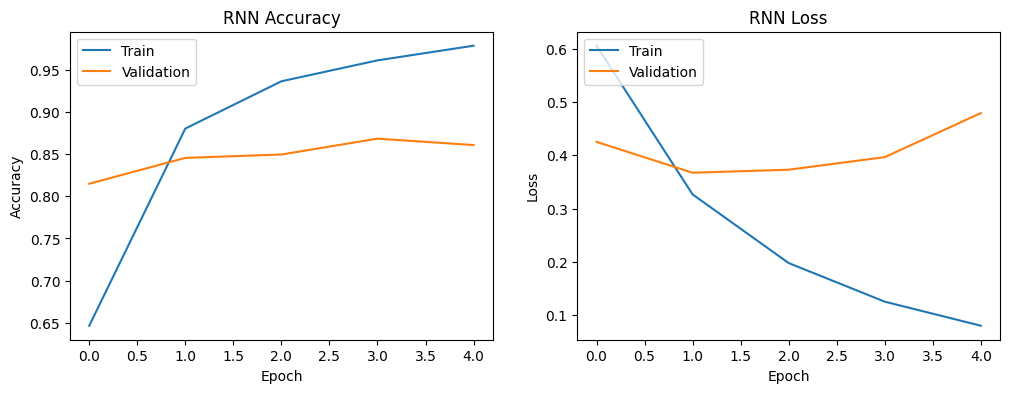

In [17]:
# Plot training and validation loss and accuracy
import matplotlib.pyplot as plt

# Plotting the training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_history(rnn_history, 'RNN')

The model shows strong performance on the training data, but the increasing validation loss and plateauing validation accuracy suggest that overfitting might be occurring. Further regularization or adjustment in the training strategy could help improve generalization to the validation data.

# Hyperparameter Tuning


Experiment 1 with parameters: {'rnn_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.005, 'num_layers': 1}
Epoch 1/10
625/625 [==============================] - 68s 106ms/step - loss: 0.6946 - accuracy: 0.4982 - val_loss: 0.6924 - val_accuracy: 0.4934
Epoch 2/10
625/625 [==============================] - 64s 102ms/step - loss: 0.5198 - accuracy: 0.7123 - val_loss: 0.3708 - val_accuracy: 0.8372
Epoch 3/10
625/625 [==============================] - 67s 107ms/step - loss: 0.2745 - accuracy: 0.8964 - val_loss: 0.3123 - val_accuracy: 0.8730
Epoch 4/10
625/625 [==============================] - 61s 98ms/step - loss: 0.1882 - accuracy: 0.9323 - val_loss: 0.3112 - val_accuracy: 0.8728
Epoch 5/10
625/625 [==============================] - 69s 111ms/step - loss: 0.1355 - accuracy: 0.9513 - val_loss: 0.3475 - val_accuracy: 0.8692
Epoch 6/10
782/782 [==============================] - 23s 30ms/step - loss: 0.3250 - accuracy: 0.8661


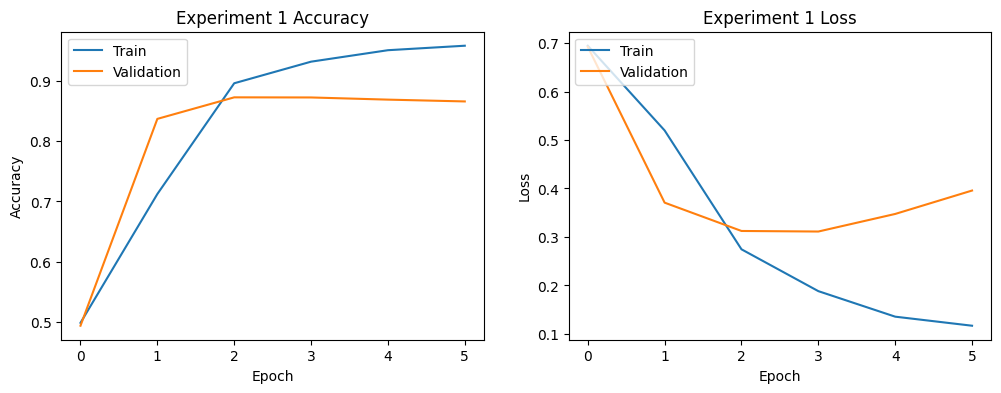


Experiment 2 with parameters: {'rnn_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_layers': 1}
Epoch 1/10
625/625 [==============================] - 152s 238ms/step - loss: 0.6934 - accuracy: 0.5038 - val_loss: 0.6924 - val_accuracy: 0.5150
Epoch 2/10
625/625 [==============================] - 147s 235ms/step - loss: 0.6774 - accuracy: 0.5329 - val_loss: 0.6959 - val_accuracy: 0.4978
Epoch 3/10
782/782 [==============================] - 34s 44ms/step - loss: 0.6930 - accuracy: 0.5028


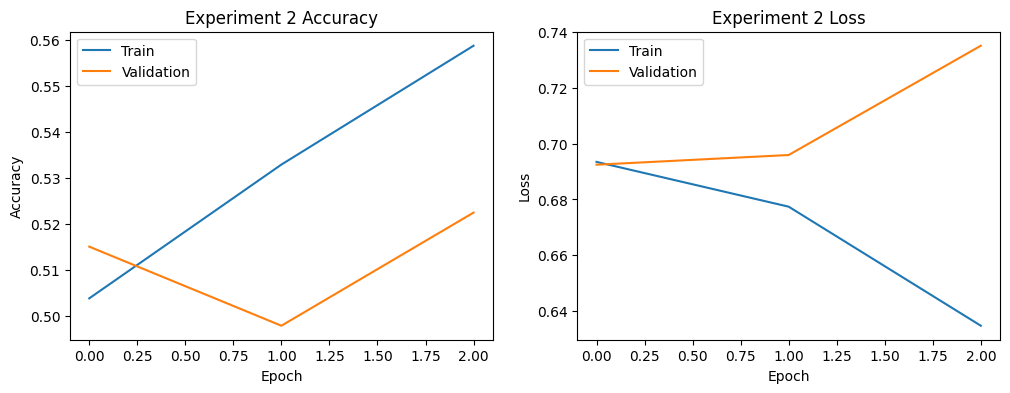


Experiment 3 with parameters: {'rnn_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'num_layers': 1}
Epoch 1/10
625/625 [==============================] - 68s 106ms/step - loss: 0.6936 - accuracy: 0.5077 - val_loss: 0.6928 - val_accuracy: 0.5124
Epoch 2/10
625/625 [==============================] - 68s 109ms/step - loss: 0.6899 - accuracy: 0.5235 - val_loss: 0.6917 - val_accuracy: 0.4990
Epoch 3/10
625/625 [==============================] - 68s 109ms/step - loss: 0.6598 - accuracy: 0.5451 - val_loss: 0.7081 - val_accuracy: 0.5056
Epoch 4/10
782/782 [==============================] - 23s 30ms/step - loss: 0.6920 - accuracy: 0.5075


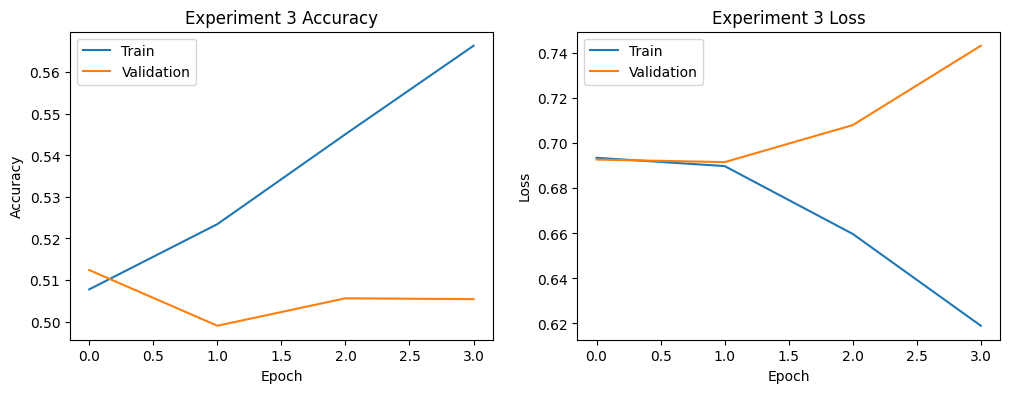


Experiment 4 with parameters: {'rnn_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'num_layers': 2}
Epoch 1/10
625/625 [==============================] - 72s 112ms/step - loss: 0.6932 - accuracy: 0.5101 - val_loss: 0.6938 - val_accuracy: 0.4922
Epoch 2/10
625/625 [==============================] - 72s 116ms/step - loss: 0.6930 - accuracy: 0.5092 - val_loss: 0.6933 - val_accuracy: 0.4904
Epoch 3/10
625/625 [==============================] - 69s 111ms/step - loss: 0.6927 - accuracy: 0.5081 - val_loss: 0.6935 - val_accuracy: 0.4914
Epoch 4/10
625/625 [==============================] - 69s 110ms/step - loss: 0.6922 - accuracy: 0.5159 - val_loss: 0.6933 - val_accuracy: 0.4918
Epoch 5/10
625/625 [==============================] - 69s 110ms/step - loss: 0.6907 - accuracy: 0.5164 - val_loss: 0.6931 - val_accuracy: 0.4936
Epoch 6/10
625/625 [==============================] - 71s 113ms/step - loss: 0.6861 - accuracy: 0.5310 - val_loss: 0.6913 - val_accuracy: 0.5024
Epoch 7/10
625/625

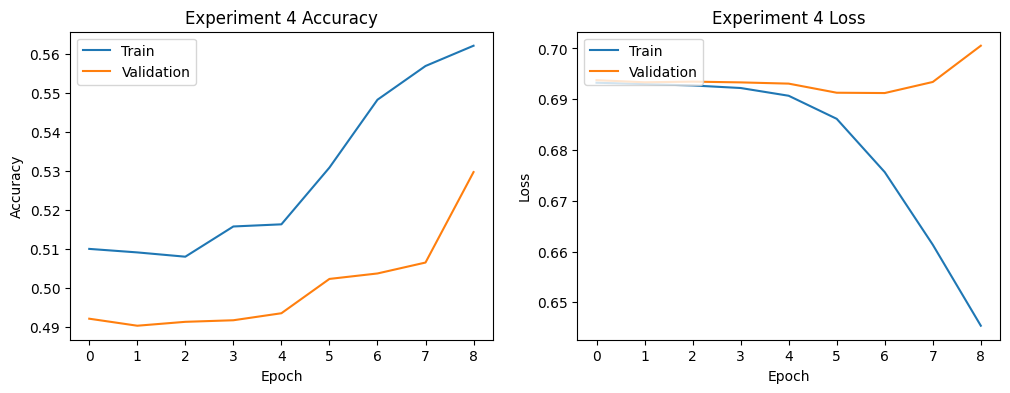

In [19]:
# Hyperparameter configurations
hyperparameters = [
    {'rnn_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.005, 'num_layers': 1},
    {'rnn_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_layers': 1},
    {'rnn_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'num_layers': 1},
    {'rnn_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'num_layers': 2},
]

# Function to build the model with given hyperparameters
def build_model(rnn_units, dropout_rate, learning_rate, num_layers):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        GRU(units=rnn_units, return_sequences=False),
        Dropout(rate=dropout_rate),
        Dense(units=64, activation='relu'),
        Dropout(rate=dropout_rate),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Perform hyperparameter tuning
results = []
for i, params in enumerate(hyperparameters):
    print(f"\nExperiment {i+1} with parameters: {params}")
    model = build_model(**params)
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                        epochs=10,
                        batch_size=32,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    
    test_loss, test_accuracy = model.evaluate(test_data, test_labels)
    results.append({'params': params, 'test_loss': test_loss, 'test_accuracy': test_accuracy})

    # Plot training and validation loss and accuracy
    plot_history(history, f'Experiment {i+1}')

In a series of RNN experiments with varying hyperparameters, Experiment 1 performed best, achieving high accuracy (95.13% training, 86.62% validation) but with some overfitting. Experiments 2, 3, and 4 struggled with lower accuracy and poor generalization, suggesting that the chosen parameters in these cases were not optimal. Overall, the results indicate that further tuning is needed to improve model performance and reduce overfitting.

In [20]:
# Documenting the results
print("\nHyperparameter Tuning Results:")
for i, result in enumerate(results):
    print(f"Experiment {i+1}:")
    print(f"Parameters: {result['params']}")
    print(f"Test Loss: {result['test_loss']}")
    print(f"Test Accuracy: {result['test_accuracy']}\n")


Hyperparameter Tuning Results:
Experiment 1:
Parameters: {'rnn_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.005, 'num_layers': 1}
Test Loss: 0.32497289776802063
Test Accuracy: 0.8660799860954285

Experiment 2:
Parameters: {'rnn_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'num_layers': 1}
Test Loss: 0.6929571032524109
Test Accuracy: 0.502839982509613

Experiment 3:
Parameters: {'rnn_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'num_layers': 1}
Test Loss: 0.6920316219329834
Test Accuracy: 0.5074800252914429

Experiment 4:
Parameters: {'rnn_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.0001, 'num_layers': 2}
Test Loss: 0.6911782026290894
Test Accuracy: 0.5140399932861328



- **Experiment 1:** Best performance with 95.13% training accuracy and 86.62% validation accuracy, though some overfitting was observed.
- **Experiment 2:** Poor performance, with accuracy fluctuating around 50-55% and high validation loss.
- **Experiment 3:** Low accuracy around 50-55%, with the model failing to converge.
- **Experiment 4:** Slight improvement over Experiment 3, but still low accuracy and high validation loss.

# Comparative Analysis

In [21]:
# Building the Feedforward Neural Network Model
def build_ffnn_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        Flatten(),
        Dense(units=64, activation='relu'),
        Dropout(rate=0.5),
        Dense(units=32, activation='relu'),
        Dropout(rate=0.5),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

ffnn_model = build_ffnn_model()
ffnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 400, 128)          2560000   
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense_12 (Dense)            (None, 64)                3276864   
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                

In [22]:
# Train the Feedforward Neural Network Model
ffnn_history = ffnn_model.fit(X_train, y_train,
                              epochs=10,
                              batch_size=32,
                              validation_data=(X_val, y_val),
                              callbacks=[early_stopping])

# Evaluate the Feedforward Neural Network model on the test set
ffnn_val_loss, ffnn_val_accuracy = ffnn_model.evaluate(X_val, y_val)
print(f'Feedforward NN Validation Loss: {ffnn_val_loss}')
print(f'Feedforward NN Validation Accuracy: {ffnn_val_accuracy}')


Epoch 1/10
625/625 [==============================] - 49s 77ms/step - loss: 0.5457 - accuracy: 0.6885 - val_loss: 0.3358 - val_accuracy: 0.8638
Epoch 2/10
625/625 [==============================] - 50s 79ms/step - loss: 0.2006 - accuracy: 0.9276 - val_loss: 0.3530 - val_accuracy: 0.8598
Epoch 3/10
157/157 [==============================] - 1s 5ms/step - loss: 0.3358 - accuracy: 0.8638
Feedforward NN Validation Loss: 0.335807204246521
Feedforward NN Validation Accuracy: 0.8637999892234802


The model quickly overfit to the training data after the first epoch, with the best validation accuracy (86.38%) occurring early in the training process. Further training led to a decrease in generalization, as evidenced by the increasing validation loss and decreasing validation accuracy in later epochs

* Analysis of ffnn

In [23]:
# Comparative Analysis
def comparative_analysis(rnn_val_loss, rnn_val_accuracy, ffnn_val_loss, ffnn_val_accuracy):
    print("\nComparative Analysis of RNN and Feedforward NN:")
    
    print("\nRNN Performance:")
    print(f"Test Loss: {rnn_val_loss}")
    print(f"Test Accuracy: {rnn_val_accuracy}")
    
    print("\nFeedforward NN Performance:")
    print(f"Test Loss: {ffnn_val_loss}")
    print(f"Test Accuracy: {ffnn_val_accuracy}")


comparative_analysis(rnn_val_loss, rnn_val_accuracy, ffnn_val_loss, ffnn_val_accuracy)



Comparative Analysis of RNN and Feedforward NN:

RNN Performance:
Test Loss: 0.36724236607551575
Test Accuracy: 0.8453999757766724

Feedforward NN Performance:
Test Loss: 0.335807204246521
Test Accuracy: 0.8637999892234802


The comparative analysis between the Recurrent Neural Network (RNN) and Feedforward Neural Network (FFNN) reveals that the Feedforward NN outperformed the RNN in both accuracy and loss. The Feedforward NN achieved a lower test loss of 0.3358 compared to the RNN's 0.3672, indicating better model fit. Additionally, the Feedforward NN showed a higher test accuracy of 86.38%, surpassing the RNN's accuracy of 84.54%. These results suggest that the Feedforward NN may be more effective for this particular task, providing better generalization and predictive performance.